# Preprocessing
In this notebook, some preprocessing steps where illustrated. In particular, the metadata of the patches, previosly created with the patching code, is used to filtering the not informative ones. In case of multiple tissue per slide, the patches are moved in different folder representing the differnt tissues. The library Histoprep is used also in this case.

In [64]:
# imports
import histoprep as hp
import os
import pandas as pd
from PIL import Image, ImageDraw
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pickle import TRUE
import shutil

In [ ]:
# Folders and variables name
path='./Output/' #Input forlder
sample='' #Specific slide name without the extation
sample_name=os.path.join(path,sample,'tile_metadata.csv')
output_folder=os.path.join(path,sample)
print('Preprocessing sample: ',sample,'\npath: ',sample_name)

In [67]:
# Load of metadata and thumbail image
metadata=pd.read_csv(sample_name)
thumbnail_path=os.path.join(output_folder,'thumbnail.jpeg')
thumbnail=Image.open(thumbnail_path).convert('RGB')
annotated_thumbnail = thumbnail.copy()
annotated = ImageDraw.Draw(annotated_thumbnail)

In [68]:
#Filter the patch with not informative infomation. The parameters and thresholds should be adjust according with dataset
filtered_coordinates=[]
filtered_xy=[]
for i in range(0,len(metadata)):
    if metadata['hue_q=0.1'][i]>144 or metadata['black_pixels'][i]>0.2 or metadata['brightness_q=0.1'][i]<45 \
    or metadata['saturation_q=0.5'][i]<30 or metadata['sharpness_max'][i]<5:

        filtered_coordinates.append(i)
        filtered_xy.append([metadata['y'][i],metadata['x'][i]])

In [69]:
# Saving of the image with the eliminated patches
width=1250
downsample = 64
w = h = int(width/downsample)
for i in filtered_coordinates:
    x_d = round(metadata['x'][i]/downsample)
    y_d = round(metadata['y'][i]/downsample)
    annotated.rectangle([x_d, y_d, x_d+w, y_d+h]
                        , outline='red', width=2)
# Deletion of the patches also in the medata file
metadata = metadata.drop(labels=filtered_coordinates, axis=0)
metadata=metadata.reset_index()
annotated_thumbnail.save(os.path.join(output_folder,'thumbnail_eliminatedTile.jpeg'))

In [ ]:
#Deletion of the low quality patches
print('Inizial number of Tiles: ',len(os.listdir(os.path.join(output_folder,'tiles'))))
print('Number of tiles to eliminate: ',len(filtered_xy))
for coord in filtered_xy:
    name_coord=output_folder+'/tiles/'+'x'+str(coord[1])+'_y'+str(coord[0])+'_w1250_h1250.png'
    os.remove(name_coord)

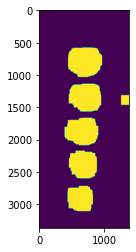

In [73]:
#Code to identify all the tissue present in the slide, expecially if there are more than one!
thumb=Image.open(os.path.join(output_folder,"thumbnail.jpeg"))

image,mask =hp.functional.detect_tissue(thumb)
kernel_size = (30,30) #Change the kernel size
mask2 = cv2.dilate(mask, np.ones(kernel_size, np.uint8), iterations=5)
plt.imshow(mask2)
contours, __ = cv2.findContours(
    mask2, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
areas = np.array([cv2.contourArea(x) for x in contours])
maxarea=max(areas) 
minarea=maxarea-(maxarea*40/100) #Change how much reduce the maximal area

#Find the bounding boxes of each tissue
cc=[]
for cnts in contours:
    aa=cv2.contourArea(cnts)
    if aa>=minarea:
        cc.append(cnts)
len(cc)
bounding_boxes = [cv2.boundingRect(cnt) for cnt in cc]

In [72]:
#If there is one tissue in the slide, this code is used to change the name of each patch to the required format. Instead, if there are more tissue in the slide, this code allows
#to save the patches in separated folders according with the tissues
for i in range(0,len(metadata)):
    j=1
    x_d = round(metadata['x'][i]/downsample)
    y_d = round(metadata['y'][i]/downsample)
    
    if len(bounding_boxes)>1:
        # Load the thumbnail image
        thumbnail_path=os.path.join(output_folder,'thumbnail.jpeg')
        thumbnail=Image.open(thumbnail_path).convert('RGB')
        annotated_thumbnail = thumbnail.copy()
        annotated = ImageDraw.Draw(annotated_thumbnail)
        width=1250
        downsample = 64
        w = h = int(width/downsample)
        color=['red','blue','green','yellow','black','magenta']
        for box in bounding_boxes:
            if (x_d>=box[0] and x_d<=box[0]+box[2]) and (y_d>=box[1] and y_d<=box[1]+box[3]):
                annotated.rectangle([x_d, y_d, x_d+w, y_d+h]
                                        , outline=color[j-1], width=4)
                folder=os.path.join(output_folder,'tiles_n'+str(j))
                if not os.path.exists(folder): 
                    os.makedirs(folder)
                #Name sostitution not only for moving the patches to the relative folder but also to change the name to the correct format required for the following steps
                old_name_coord=output_folder+'/tiles/'+'x'+str(metadata['x'][i])+'_y'+str(metadata['y'][i])+'_w1250_h1250.png'
                new_name_coord=folder+'/'+'x-'+str(metadata['x'][i])+'_y-'+str(metadata['y'][i])+'.png'
                shutil.move(old_name_coord, new_name_coord)
            j+=1
        annotated_thumbnail.save(os.path.join(output_folder,'thumbnail_diff_tissue.jpeg'))
        for i in range(0,len(bounding_boxes)):
            print('Tile number n: ',i+1,'with color: ',color[i])

    elif len(bounding_boxes)==1:
        #Name sostitution to change the name to the correct format required for the following steps
            old_name_coord=output_folder+'/tiles/'+'x'+str(metadata['x'][i])+'_y'+str(metadata['y'][i])+'_w1250_h1250.png'
            new_name_coord=output_folder+'/tiles/'+'x-'+str(metadata['x'][i])+'_y-'+str(metadata['y'][i])+'.png'
            shutil.move(old_name_coord, new_name_coord)

